In [2]:
import pandas as pd, pyarrow
from pathlib import Path
from sympy import init_printing
init_printing()
import numpy as np

In [3]:
RAW_PATH = Path("/Users/angryissues/python_projects/ML/data/raw/News_Category_Dataset_v3.json")
df = pd.read_json(RAW_PATH, lines=True)

df["text"] = df["headline"] + " " + df["short_description"]
df[["category", "text", "date"]].head()

,category,text,date
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,2022-09-23
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",2022-09-23
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,2022-09-23
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,2022-09-23
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,2022-09-22


In [4]:
df["date"] = pd.to_datetime(df["date"])

In [5]:
import nltk, json
from nltk.corpus import stopwords

In [6]:
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

CUSTOM_STOP = {"u", "us", "’s", "“", "”", "–", "…"}
STOPWORDS.update(CUSTOM_STOP)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angryissues/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import re, emoji, spacy
from string import punctuation
from pathlib import Path

In [8]:
NLP = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [9]:
URL_RE   = re.compile(r"https?://\S+|www\.\S+")
HTML_RE  = re.compile(r"<.*?>")
NUM_RE   = re.compile(r"\d+")
PUNCT_TBL = str.maketrans("", "", punctuation)

In [10]:
def clean_text(text: str) -> list[str]:
    text = text.lower()                    # 1) lowercase
    text = URL_RE.sub(" ", text)           # 2) remove urls
    text = HTML_RE.sub(" ", text)          # 3) strip html tags
    text = emoji.replace_emoji(text, " ")  # 4) drop emoji
    text = NUM_RE.sub(" ", text)           # 5) drop pure numbers
    text = text.translate(PUNCT_TBL)       # 6) drop punctuation

    doc = NLP(text)                        # 7) tokenize & lemmatize
    tokens = [
        tok.lemma_ for tok in doc
        if tok.is_alpha                  # только буквенные
        and tok.lemma_ not in STOPWORDS  # не стоп-слова
        and len(tok) > 2                 # длина ≥ 3 символа
    ]
    return tokens

In [11]:
from tqdm.auto import tqdm
tqdm.pandas()

/Users/angryissues/python_projects/ML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
df["tokens"] = df["text"].progress_apply(clean_text)

100%|██████████| 209527/209527 [06:38<00:00, 525.56it/s]


Промежуточный результат

In [13]:
df[["headline", "tokens"]].head(4)

,headline,tokens
0,Over 4 Million Americans Roll Up Sleeves For O...,"[million, americans, roll, sleeve, omicrontarg..."
1,"American Airlines Flyer Charged, Banned For Li...","[american, airlines, flyer, charge, ban, life,..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,"[funniest, tweet, cat, dog, week, sept, dog, u..."
3,The Funniest Tweets From Parents This Week (Se...,"[funniest, tweet, parent, week, sept, accident..."


In [15]:
PROCESSED = Path("data/raw/news_tokens.parquet")
df[["category", "date", "tokens"]].to_parquet(PROCESSED, index=False)

In [16]:
# Сколько слов в словаре
vocab = {tok for row in df["tokens"] for tok in row}
print("Vocabulary size:", len(vocab))

Vocabulary size: 94238


In [17]:
# Средняя длина документа
print("Avg tokens per doc:", df["tokens"].str.len().mean())

Avg tokens per doc: 16.89762178621371


Дескриптивная статистика и визуализации

In [18]:
# Базовая сводка корпуса
docs   = len(df)
tokens = df["tokens"].explode()
vocab  = tokens.nunique()
ttr    = vocab / tokens.size
hapax  = (tokens.value_counts() == 1).mean() * 100

print(f"Документов     : {docs:,}")
print(f"Всех токенов   : {tokens.size:,}")
print(f"Уникальных слов: {vocab:,}")
print(f"TTR            : {ttr:.3f}")
print(f"Hapax %        : {hapax:.1f}%")

Документов     : 209,527
Всех токенов   : 3,540,528
Уникальных слов: 94,238
TTR            : 0.027
Hapax %        : 48.6%


In [19]:
# Частотные таблицы
TOP_K = 30

# все слова
freq_all = tokens.value_counts().head(TOP_K)

# по категориям ─ словарь {cat: Series}
freq_cat = (
    df.explode("tokens")
      .groupby("category")["tokens"]
      .value_counts()
      .groupby(level=0)
      .head(TOP_K)
      .reset_index(name="freq")
)

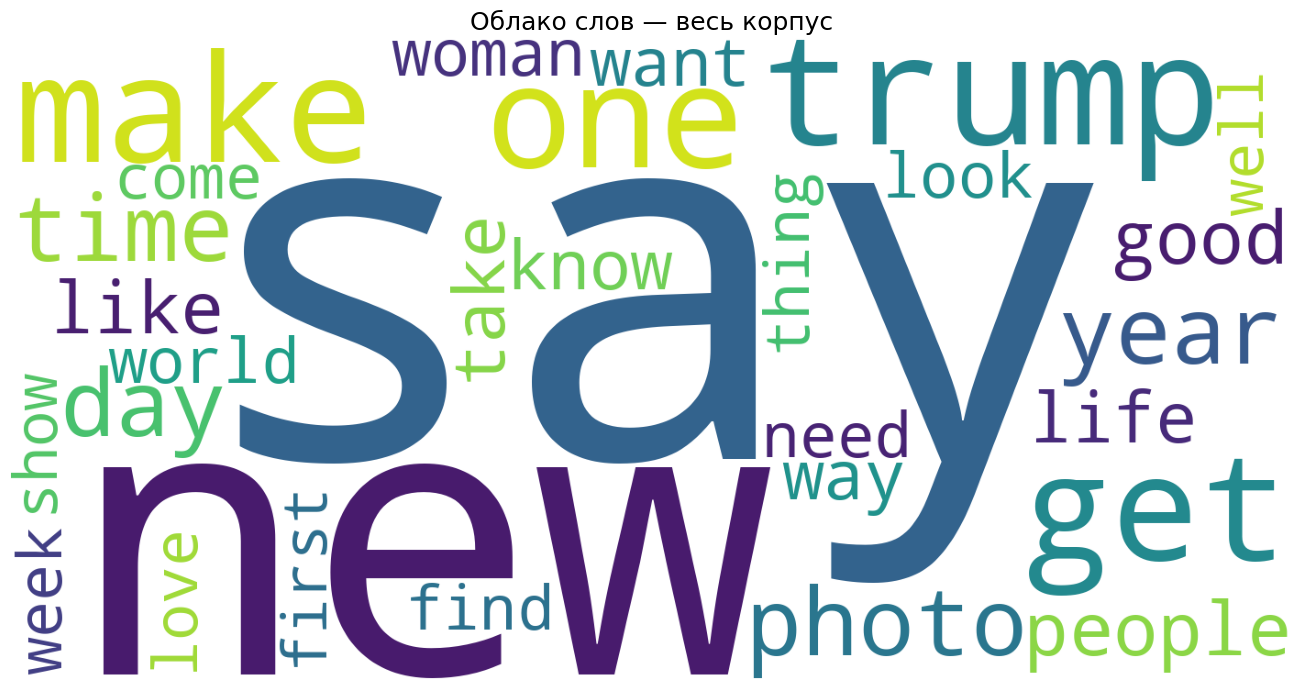

In [20]:
#  WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=1400, height=700,
               background_color="white",
               collocations=False)       # чтобы биграммы не склеивало

plt.figure(figsize=(14,7))
plt.imshow(wc.generate_from_frequencies(freq_all.to_dict()))
plt.axis("off")
plt.title("Облако слов — весь корпус", size=18)
plt.tight_layout(); plt.show()

Лидер частоты — say, за ним new, trump, make, get, one и т.д.

Перед обучением моделей стоит дополнительно отфильтровать «полуустойчивые» стоп‑слова (say, make, get, one).

Популярность trump и photo указывает на значительный пласт политических и развлекательных новостей.

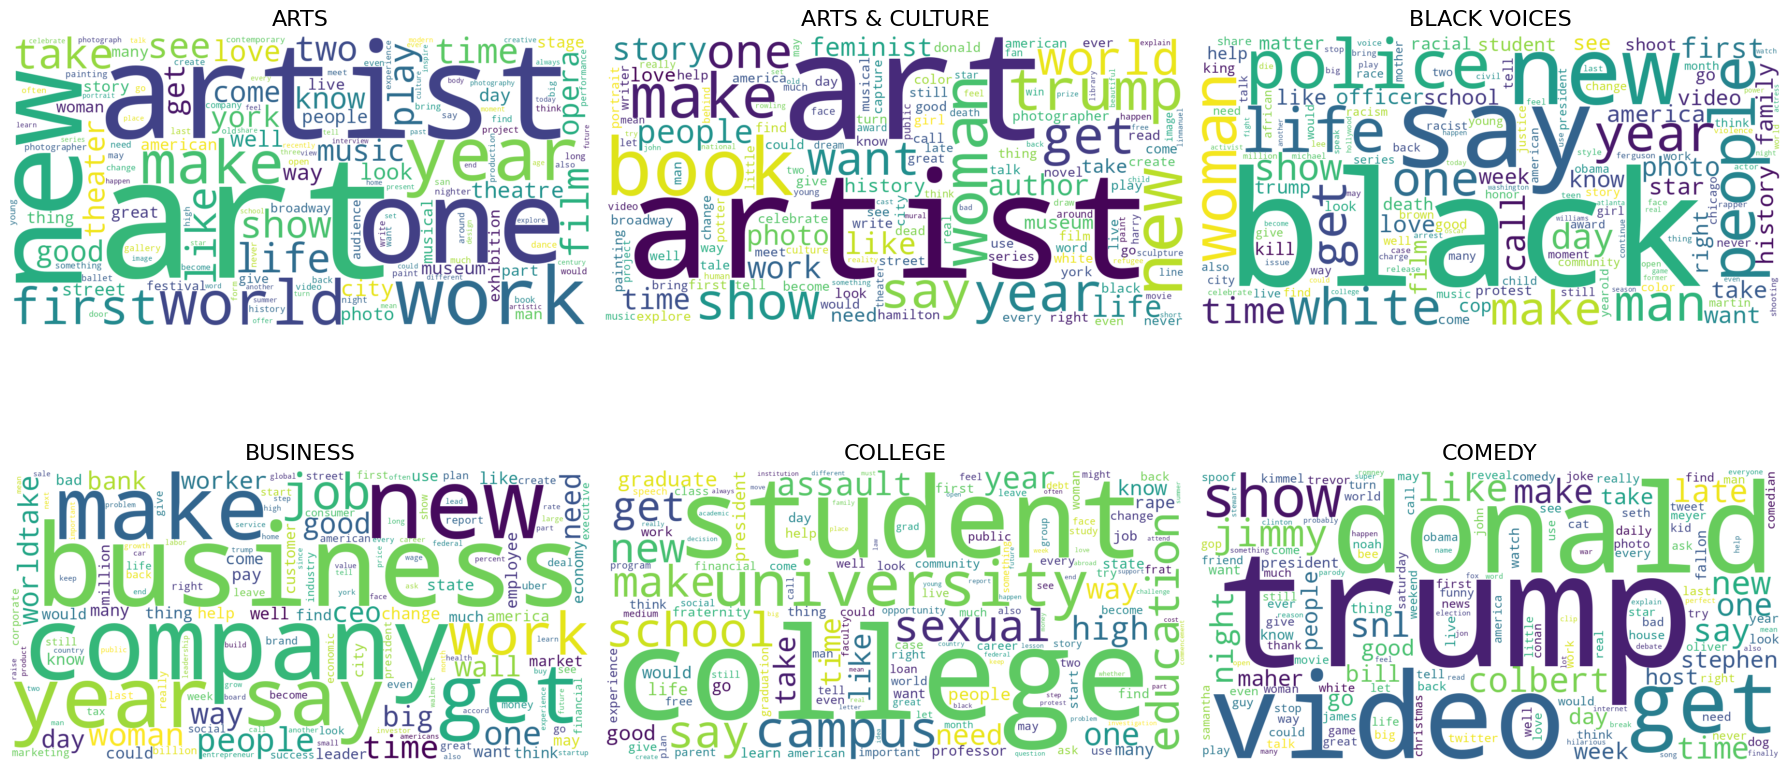

In [21]:
# По категориям
TOP_N = 150          # сколько слов берём для облака

freq_cat = (
    df.explode("tokens")
      .groupby("category")["tokens"]
      .value_counts()
      .groupby(level=0)
      .head(TOP_N)                    # top-N внутри каждой категории
      .reset_index(name="freq")
)

# 2. список уникальных категорий (можно отсортировать по алфавиту)
cats = sorted(freq_cat["category"].unique())

# 3. создаём выходную папку
out_dir = Path("figures/wordclouds")
out_dir.mkdir(parents=True, exist_ok=True)

# 4. строим на сетке 2 × 3 (подойдёт для 6 категорий; измените при желании)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

wc = WordCloud(width=1200, height=600,
               background_color="white",
               collocations=False)

for ax, cat in zip(axes.flatten(), cats):
    grp = freq_cat[freq_cat["category"] == cat]
    freq_dict = dict(zip(grp["tokens"], grp["freq"]))
    img = wc.generate_from_frequencies(freq_dict)

    ax.imshow(img, interpolation="bilinear")
    ax.set_title(cat, fontsize=16, pad=8)
    ax.axis("off")

    # (опц.) сохранить отдельный файл
    img.to_file(out_dir / f"{cat}_wordcloud.png")

plt.tight_layout()
plt.show()

• ARTS / ARTS & CULTURE — доминируют artist, art, book, feminist.
• BLACK VOICES — black, police, white, year, people → фокус на расовой повестке и правоохранительных темах.
• BUSINESS — company, business, job, make — корпоративная лексика.
• COLLEGE — student, university, sexual, campus — студенческая и #MeToo‑повестка.
• COMEDY — trump, video, show, donald, colbert — привязка к политической сатире.

Слова действительно отражают тематику рубрик → модель классификации сможет опираться на ключевую лексику.

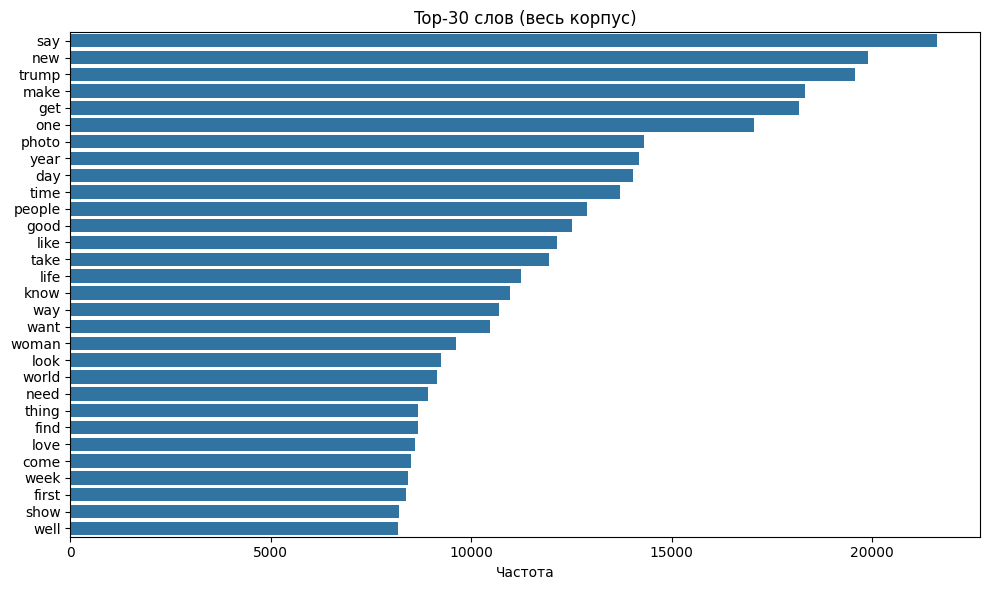

In [22]:
# Bar‑chart TOP‑N слов

import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x=freq_all.values, y=freq_all.index, orient="h")
plt.title("Top‑30 слов (весь корпус)")
plt.xlabel("Частота"); plt.ylabel("")
plt.tight_layout(); plt.show()

• Частотный ряд подтверждает облако: после «большой семёрки» частоты резко падают.

• good, like, time, life — слова общего характера.

In [23]:
# Heatmap «слово × месяц»
keywords = ["covid", "election", "china", "gun", "abortion", "inflation", "well", "hugs"]
df["month"] = df["date"].dt.to_period("M").astype(str)

In [24]:
def contains_word(text, word):
    return word in text

heat = (
    df[["month","tokens"]]
      .assign(**{w: df["tokens"].apply(lambda x, w=w: w in x).astype(int)
                 for w in keywords})
      .groupby("month")[keywords].sum()
)

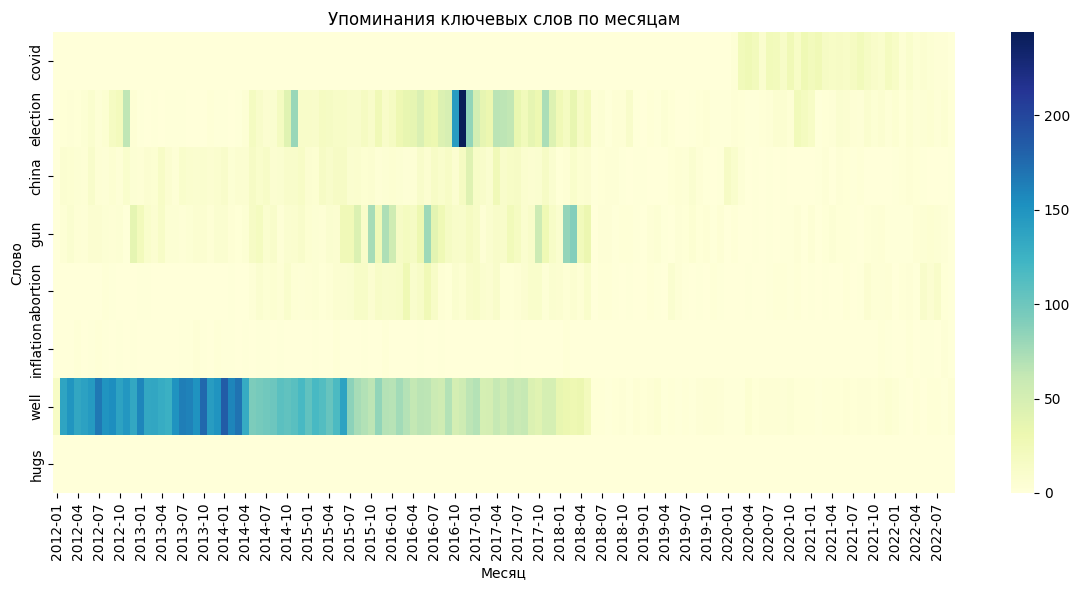

In [25]:
plt.figure(figsize=(12,6))
sns.heatmap(heat.T, cmap="YlGnBu")
plt.title("Упоминания ключевых слов по месяцам")
plt.xlabel("Месяц"); plt.ylabel("Слово")
plt.tight_layout(); plt.show()

• election & trump — чёткие пики 2016 г. (президентские выборы) и уменьшение после 2021 г.

• covid появляется только c 2020‑01, максимум — середина 2020 г.

• gun имеет периодические всплески → корреляция с масштабными происшествиями.

• inflation, abortion — редкие, но ускоряются к 2022 г.

• well («заглушка» из выражений well‑being/“well”) держится на высоком уровне всегда → неинформативно.

In [26]:
# Интерактивный bubble‑chart
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px

vec = TfidfVectorizer(max_features=20_000, ngram_range=(1,1))
X   = vec.fit_transform(df["text"])

idf  = vec.idf_
vocs = np.array(vec.get_feature_names_out())

top  = idf.argsort()[:200]

freq_series = tokens.value_counts()

data = pd.DataFrame({
    "word": vocs[top],
    "idf" : idf[top],
    "freq": freq_series.reindex(vocs[top]).fillna(0).values   # ← ключевая правка
})

fig = px.scatter(data, x="idf", y="freq", text="word",
                 size="freq", log_y=True, height=600,
                 title="TF‑IDF vs Frequency (пузырь = частота)")
fig.show()

• Две плотные «тучи»:

  — слева‑вверху (низкий idf, высокая freq) — общеупотребительные слова (say, new, people).

  — справа‑ниже (высокий idf, средняя freq) — более “специфичные” (women, children, photos, covid, shooting).

• Самые информативные токены — с idf ≈ 4‑5 и freq 200‑2 000 (редкие, но не уникальные).